# Exploring Different RL Algorithms to Solve the Classic Cart-Pole Problem
Kristin Lomicka, Drena Miftari and Chloe Maine \
July 3, 2020

## Problem Description
The Cartpole problem is a classic "inverted pendulum" reinforcement learning problem that seeks to keep a pole on a cart remaining up right. The pole initially starts out unstable, but the cart can be directed left and right with the aim to keep the pole balanced by applying appropriate actions for its movements.

There are many different reinforcement learning algorithms that can be applied to the cartpole problem to maintain its balance. We took inspiration from the research outlined in "Comparison of Reinforcement Learning Algorithms applied to the Cart-Pole Problem" (Nagendra et al. (2017)), where they evaluted four algorithm performances with the cartpole problem: temporal-difference, policy gradient actor-critic, and value function approximation are compared in this context with the standard LQR solution.

For this project, we applied the following two algorithms:
- Temportal Difference (Q-Learning)
- Policy Gradient Actor Critic

We also leverage the paper titled, "Continuous Control with Deep Reinforcement Learning" by Lillicrap et al. (Google Deepmind, 2016) for our implementationn of the Actor Critic model.

The cartpole problem is considered solved when the pole is able to stay upright for an average of 195 steps over 100 trials. Using the algorithms above, we optimized the policies to determine which algorithm was able to solve the problem the fastest and more consistently.

Additionally, we used OpenAI Gym to train our model and simulate the learning process.

## A simple agent to control the cart
To get our feet wet with OpenAI Gym, we created a simple agent that pushes the cart to the right if the angle of the pole is greater than 0 and to the left if the angle is less than or equal to 0.

In [63]:
import gym
import numpy as np
import math
from gym import spaces
import random
from collections import deque
import matplotlib.pyplot as plt

In [5]:
class SimpleAgent():
    def __init__(self, env):
        self.action_size = env.action_space.n # number of actions available - 2 in this case
        self.observation_space = env.observation_space
    def get_action(self, state):
        pole_angle = state[2]
        if pole_angle > 0:
            action = 1 # Choose random action from available actions
        else:
            action = 0
        return action

env = gym.make('CartPole-v1')
agent = SimpleAgent(env)
state = env.reset() # define initial state

for i in range(500):
    env.render() # render visual
    action = agent.get_action(state) # select action given the state
    state, reward, done, info = env.step(action) # apply action to the environment and get results                                          # returns the next state, reward, whether terminal state was reached, additional info
print('Final state:')
print('Cart Position: ' + str(state[0]))
print('Cart Velocity: ' + str(state[1]))
print('Pole Angle: ' + str(state[2]))
print('Pole Velocity at Tip: ' + str(state[3]))
print(done)
     
env.close()
    

Final state:
Cart Position: -272.387447123274
Cart Velocity: -70.54799612458923
Pole Angle: -54.99414608881169
Pole Velocity at Tip: -11.267069645093764
True


The thresholds for episode termination are below. As we can see, the final state exceeded the limits for termination.
- Pole angle is more than +/- 12 degrees
- Cart position is more than +/-2.4 (center of the cart reaches the edge of the display)
- Episode length is greater than 500

## Algorithm 1: Q-Learning

Q-Learning is a technique to identify optimal policies in a reinforcement learning program. Through various runs (episodes), the program finds a Q-value for each state and action. This Q-value, which is stored in a Q-table, shows how well an action performed in that specific state. As the episodes, or iterations, increase the program would learn and these values would eventually converge and the resulting Q-table would show which action has the highest reward, which would be the optimal policy given that state.

The Q-value is calculated as

$$Q(S_t,A_t)=Q(S_t,A_t)+\alpha[R_t+\gamma \max_{a^\prime} Q(S_t+1,a')-Q(S_t,A_t)]$$

where $(S_t,A_t)$ is the current state and action, $(S_t+1,a')$ is the following state and action, $A_t$ is the action, and $R_t$ is the reward. It's important to note that we observed in our research that in Q-learning, one can choose to have either positive rewards for 'good behaviour' -- in our case keeping the pole upright -- or negative rewards for 'bad behaviour'. We chose to apply positive rewards to our algorithm and would, as a future step, explore if there is a difference in results between the two methods.

Overall, in this environment, the program gets a reward with every movement that the pole remains upright within a defined angle bound. With every episode the total rewards are accumulated and stored with the episode ending if the pole falls over. After 100 episodes, the average reward over the last 100 episodes starts to be calculated. Once this average reward is above a certain value which we call "solved" -- in our case this was a value of 195 rewards -- then the program is considered solved and finishes.

The program implements 300 episodes and averages the rewards to assess the results.

In [64]:
# creating the cartpole environment using the gym package
environment = gym.make('CartPole-v1')


class CartpoleProblem():
    ''' 
    Cartpole class which applies a reinforcement learning
    algorithm using Q-learning to identify the optimal
    policy to keep the pole upright.
    '''
    
    def __init__(self, buckets = (1, 1, 6, 3,), num_episodes = 300, solved_t = 195,
                min_epsilon = 0.1, min_alpha = 0.1, gamma = 0.99):
        # values for position, velocity, angle, angular velocity
        self.buckets = buckets  
        # setting the number of episodes to run
        self.num_episodes = num_episodes
        # defining the alpha
        self.min_alpha = min_alpha
        # definig the epsilon
        self.min_epsilon = min_epsilon
        # defining the discount factor for the rewards
        self.gamma = gamma 
        # setting the minimum average rewards to "solve" the problem
        self.solved_t = solved_t  
        # initiating the Q table for the left and right action of the pole
        self.Q = np.zeros(self.buckets + (environment.action_space.n, ))
        

    def quantify_state(self, state):
        # setting the bounds for the buckets
        upper_bound = environment.observation_space.high
        lower_bound = environment.observation_space.low
        
        # the angle and velocity are set manually
        upper_bound[1] = 0.5
        upper_bound[3] = math.radians(50)
        lower_bound[1] = -0.5
        lower_bound[3] = -math.radians(50)

        # quantifinying each of the above bounds into the buckets
        width = [upper_bound[i] - lower_bound[i] for i in range(len(state))]
        ratios = [(state[i] - lower_bound[i]) / width[i] for i in range(len(state))]
        bucket_idx = [int(round(ratios[i] * (self.buckets[i] - 1))) for i in range(len(state))]
        bucket_idx = [max(0, min(bucket_idx[i], self.buckets[i] - 1)) for i in range(len(state))]

        return tuple(bucket_idx)


    def select_action(self, state, epsilon):
        # initiating the epsilon-greedy algorithm
        if random.random() <= epsilon:
            # select random action
            return environment.action_space.sample()
        else:
            # or else select action with the largest Q value
            return np.argmax(self.Q[state]) 


    def get_epsilon(self, episode_number):
        # get a decreasing epsilon as the episodes increase
        return max(self.min_epsilon, min(1, 1 - math.log10((episode_number + 1) / 25)))


    def get_alpha(self, episode_number): 
        # get a decreasing alpha as the episdoes increase
        return max(self.min_alpha, min(1, 1 - math.log10((episode_number + 1) / 25)))


    def update_Q(self, old_state, action, reward, new_state, alpha):
        # update the Q table with the new state action pairs
        new_state_Q_value = np.max(self.Q[new_state])
        self.Q[old_state][action] += alpha * (reward + self.gamma * new_state_Q_value - self.Q[old_state][action])

    
    
    def run(self):
        # run the program for num_episodes, and stop if the average reward over 100 episodes is
        # above the minimum solved_t defined above
        scores = deque(maxlen = 100)
        
        for episode in range(self.num_episodes):
            done = False
            alpha = self.get_alpha(episode)
            epsilon = self.get_epsilon(episode)
            ep_reward = 0

            observed = environment.reset()
            current_state = self.quantify_state(observed)
            
            
            while not done:
                environment.render()
                action = self.select_action(current_state, epsilon)
                observed, reward, done, _ = environment.step(action)
                new_state = self.quantify_state(observed)

                self.update_Q(current_state, action, reward, new_state, alpha)
                current_state = new_state
                # accumulate rewards while pole is still upright
                ep_reward += reward
                
            # average the rewards over the last 100 episodes
            scores.append(ep_reward)
            average_reward = np.mean(scores)
            
            # append rewards to the learing journey to plot
            learning_journey_rewards.append(ep_reward)
            
            if average_reward > self.solved_t and (episode + 1) >= 100:
                print(f"Total Episodes: {episode+1}, but solved at Episode {episode+1-100}")
            elif (episode + 1) % 50 == 0 and (episode + 1) >= 100:
                print(f"Episode: {episode+1}, Average Score over last 100 Episodes: {average_reward}") 
            else:
                print(f"Episode: {episode+1}, Score: {ep_reward}")

In [65]:
# Run the Q learning algorithm for 25 iterations to average the rewards

iterations = 25 

total_rewards = [[] for _ in range(iterations)]

for i in range(iterations):
    # list to store the rewards and episodes
    learning_journey_rewards = []
    learning_journey_episodes = []
    
    # run the cartpole algorithm
    cartpole = CartpoleProblem()
    cartpole.run()
    
    # append rewards per iteration to a separate list    
    total_rewards[i].append(learning_journey_rewards)
    
    print(f'********************Iteration {i} Completed********************')

Episode: 1, Score: 18.0
Episode: 2, Score: 19.0
Episode: 3, Score: 14.0
Episode: 4, Score: 45.0
Episode: 5, Score: 25.0
Episode: 6, Score: 9.0
Episode: 7, Score: 72.0
Episode: 8, Score: 15.0
Episode: 9, Score: 14.0
Episode: 10, Score: 33.0
Episode: 11, Score: 25.0
Episode: 12, Score: 13.0
Episode: 13, Score: 9.0
Episode: 14, Score: 26.0
Episode: 15, Score: 16.0
Episode: 16, Score: 16.0
Episode: 17, Score: 9.0
Episode: 18, Score: 16.0
Episode: 19, Score: 13.0
Episode: 20, Score: 28.0
Episode: 21, Score: 12.0
Episode: 22, Score: 29.0
Episode: 23, Score: 32.0
Episode: 24, Score: 17.0
Episode: 25, Score: 26.0
Episode: 26, Score: 22.0
Episode: 27, Score: 9.0
Episode: 28, Score: 17.0
Episode: 29, Score: 22.0
Episode: 30, Score: 16.0
Episode: 31, Score: 13.0
Episode: 32, Score: 28.0
Episode: 33, Score: 10.0
Episode: 34, Score: 54.0
Episode: 35, Score: 23.0
Episode: 36, Score: 16.0
Episode: 37, Score: 15.0
Episode: 38, Score: 21.0
Episode: 39, Score: 15.0
Episode: 40, Score: 13.0
Episode: 41, 

Total Episodes: 266, but solved at Episode 166
Total Episodes: 267, but solved at Episode 167
Total Episodes: 268, but solved at Episode 168
Total Episodes: 269, but solved at Episode 169
Total Episodes: 270, but solved at Episode 170
Total Episodes: 271, but solved at Episode 171
Total Episodes: 272, but solved at Episode 172
Total Episodes: 273, but solved at Episode 173
Total Episodes: 274, but solved at Episode 174
Total Episodes: 275, but solved at Episode 175
Total Episodes: 276, but solved at Episode 176
Total Episodes: 277, but solved at Episode 177
Total Episodes: 278, but solved at Episode 178
Total Episodes: 279, but solved at Episode 179
Total Episodes: 280, but solved at Episode 180
Total Episodes: 281, but solved at Episode 181
Total Episodes: 282, but solved at Episode 182
Total Episodes: 283, but solved at Episode 183
Total Episodes: 284, but solved at Episode 184
Total Episodes: 285, but solved at Episode 185
Total Episodes: 286, but solved at Episode 186
Total Episode

Total Episodes: 229, but solved at Episode 129
Total Episodes: 230, but solved at Episode 130
Total Episodes: 231, but solved at Episode 131
Total Episodes: 232, but solved at Episode 132
Total Episodes: 233, but solved at Episode 133
Total Episodes: 234, but solved at Episode 134
Total Episodes: 235, but solved at Episode 135
Total Episodes: 236, but solved at Episode 136
Total Episodes: 237, but solved at Episode 137
Total Episodes: 238, but solved at Episode 138
Total Episodes: 239, but solved at Episode 139
Total Episodes: 240, but solved at Episode 140
Total Episodes: 241, but solved at Episode 141
Total Episodes: 242, but solved at Episode 142
Total Episodes: 243, but solved at Episode 143
Total Episodes: 244, but solved at Episode 144
Total Episodes: 245, but solved at Episode 145
Total Episodes: 246, but solved at Episode 146
Total Episodes: 247, but solved at Episode 147
Total Episodes: 248, but solved at Episode 148
Total Episodes: 249, but solved at Episode 149
Total Episode

Episode: 185, Score: 488.0
Episode: 186, Score: 500.0
Episode: 187, Score: 500.0
Episode: 188, Score: 500.0
Episode: 189, Score: 500.0
Total Episodes: 190, but solved at Episode 90
Total Episodes: 191, but solved at Episode 91
Total Episodes: 192, but solved at Episode 92
Total Episodes: 193, but solved at Episode 93
Total Episodes: 194, but solved at Episode 94
Total Episodes: 195, but solved at Episode 95
Total Episodes: 196, but solved at Episode 96
Total Episodes: 197, but solved at Episode 97
Total Episodes: 198, but solved at Episode 98
Total Episodes: 199, but solved at Episode 99
Total Episodes: 200, but solved at Episode 100
Total Episodes: 201, but solved at Episode 101
Total Episodes: 202, but solved at Episode 102
Total Episodes: 203, but solved at Episode 103
Total Episodes: 204, but solved at Episode 104
Total Episodes: 205, but solved at Episode 105
Total Episodes: 206, but solved at Episode 106
Total Episodes: 207, but solved at Episode 107
Total Episodes: 208, but solv

Episode: 118, Score: 15.0
Episode: 119, Score: 16.0
Episode: 120, Score: 9.0
Episode: 121, Score: 19.0
Episode: 122, Score: 8.0
Episode: 123, Score: 20.0
Episode: 124, Score: 20.0
Episode: 125, Score: 260.0
Episode: 126, Score: 279.0
Episode: 127, Score: 53.0
Episode: 128, Score: 10.0
Episode: 129, Score: 47.0
Episode: 130, Score: 36.0
Episode: 131, Score: 32.0
Episode: 132, Score: 13.0
Episode: 133, Score: 19.0
Episode: 134, Score: 9.0
Episode: 135, Score: 11.0
Episode: 136, Score: 21.0
Episode: 137, Score: 20.0
Episode: 138, Score: 272.0
Episode: 139, Score: 27.0
Episode: 140, Score: 12.0
Episode: 141, Score: 21.0
Episode: 142, Score: 11.0
Episode: 143, Score: 348.0
Episode: 144, Score: 500.0
Episode: 145, Score: 70.0
Episode: 146, Score: 10.0
Episode: 147, Score: 48.0
Episode: 148, Score: 199.0
Episode: 149, Score: 10.0
Episode: 150, Average Score over last 100 Episodes: 46.97
Episode: 151, Score: 500.0
Episode: 152, Score: 500.0
Episode: 153, Score: 500.0
Episode: 154, Score: 500.0

Episode: 53, Score: 55.0
Episode: 54, Score: 27.0
Episode: 55, Score: 52.0
Episode: 56, Score: 18.0
Episode: 57, Score: 33.0
Episode: 58, Score: 25.0
Episode: 59, Score: 11.0
Episode: 60, Score: 64.0
Episode: 61, Score: 26.0
Episode: 62, Score: 21.0
Episode: 63, Score: 10.0
Episode: 64, Score: 21.0
Episode: 65, Score: 24.0
Episode: 66, Score: 10.0
Episode: 67, Score: 33.0
Episode: 68, Score: 16.0
Episode: 69, Score: 90.0
Episode: 70, Score: 36.0
Episode: 71, Score: 15.0
Episode: 72, Score: 13.0
Episode: 73, Score: 22.0
Episode: 74, Score: 11.0
Episode: 75, Score: 20.0
Episode: 76, Score: 25.0
Episode: 77, Score: 13.0
Episode: 78, Score: 23.0
Episode: 79, Score: 29.0
Episode: 80, Score: 119.0
Episode: 81, Score: 14.0
Episode: 82, Score: 34.0
Episode: 83, Score: 12.0
Episode: 84, Score: 139.0
Episode: 85, Score: 9.0
Episode: 86, Score: 10.0
Episode: 87, Score: 41.0
Episode: 88, Score: 13.0
Episode: 89, Score: 98.0
Episode: 90, Score: 29.0
Episode: 91, Score: 19.0
Episode: 92, Score: 47.0

Episode: 76, Score: 28.0
Episode: 77, Score: 14.0
Episode: 78, Score: 21.0
Episode: 79, Score: 32.0
Episode: 80, Score: 223.0
Episode: 81, Score: 27.0
Episode: 82, Score: 21.0
Episode: 83, Score: 12.0
Episode: 84, Score: 22.0
Episode: 85, Score: 20.0
Episode: 86, Score: 32.0
Episode: 87, Score: 28.0
Episode: 88, Score: 183.0
Episode: 89, Score: 40.0
Episode: 90, Score: 22.0
Episode: 91, Score: 38.0
Episode: 92, Score: 44.0
Episode: 93, Score: 11.0
Episode: 94, Score: 75.0
Episode: 95, Score: 18.0
Episode: 96, Score: 9.0
Episode: 97, Score: 25.0
Episode: 98, Score: 33.0
Episode: 99, Score: 27.0
Episode: 100, Average Score over last 100 Episodes: 30.82
Episode: 101, Score: 9.0
Episode: 102, Score: 148.0
Episode: 103, Score: 26.0
Episode: 104, Score: 19.0
Episode: 105, Score: 16.0
Episode: 106, Score: 11.0
Episode: 107, Score: 15.0
Episode: 108, Score: 23.0
Episode: 109, Score: 9.0
Episode: 110, Score: 8.0
Episode: 111, Score: 126.0
Episode: 112, Score: 14.0
Episode: 113, Score: 84.0
Epis

Episode: 24, Score: 26.0
Episode: 25, Score: 26.0
Episode: 26, Score: 31.0
Episode: 27, Score: 14.0
Episode: 28, Score: 12.0
Episode: 29, Score: 16.0
Episode: 30, Score: 18.0
Episode: 31, Score: 30.0
Episode: 32, Score: 14.0
Episode: 33, Score: 74.0
Episode: 34, Score: 11.0
Episode: 35, Score: 29.0
Episode: 36, Score: 13.0
Episode: 37, Score: 11.0
Episode: 38, Score: 26.0
Episode: 39, Score: 10.0
Episode: 40, Score: 30.0
Episode: 41, Score: 19.0
Episode: 42, Score: 12.0
Episode: 43, Score: 27.0
Episode: 44, Score: 19.0
Episode: 45, Score: 42.0
Episode: 46, Score: 13.0
Episode: 47, Score: 40.0
Episode: 48, Score: 15.0
Episode: 49, Score: 30.0
Episode: 50, Score: 15.0
Episode: 51, Score: 20.0
Episode: 52, Score: 23.0
Episode: 53, Score: 24.0
Episode: 54, Score: 15.0
Episode: 55, Score: 11.0
Episode: 56, Score: 56.0
Episode: 57, Score: 12.0
Episode: 58, Score: 16.0
Episode: 59, Score: 26.0
Episode: 60, Score: 13.0
Episode: 61, Score: 54.0
Episode: 62, Score: 19.0
Episode: 63, Score: 57.0


Total Episodes: 274, but solved at Episode 174
Total Episodes: 275, but solved at Episode 175
Total Episodes: 276, but solved at Episode 176
Total Episodes: 277, but solved at Episode 177
Total Episodes: 278, but solved at Episode 178
Total Episodes: 279, but solved at Episode 179
Total Episodes: 280, but solved at Episode 180
Total Episodes: 281, but solved at Episode 181
Total Episodes: 282, but solved at Episode 182
Total Episodes: 283, but solved at Episode 183
Total Episodes: 284, but solved at Episode 184
Total Episodes: 285, but solved at Episode 185
Total Episodes: 286, but solved at Episode 186
Total Episodes: 287, but solved at Episode 187
Total Episodes: 288, but solved at Episode 188
Total Episodes: 289, but solved at Episode 189
Total Episodes: 290, but solved at Episode 190
Total Episodes: 291, but solved at Episode 191
Total Episodes: 292, but solved at Episode 192
Total Episodes: 293, but solved at Episode 193
Total Episodes: 294, but solved at Episode 194
Total Episode

Total Episodes: 233, but solved at Episode 133
Total Episodes: 234, but solved at Episode 134
Total Episodes: 235, but solved at Episode 135
Total Episodes: 236, but solved at Episode 136
Total Episodes: 237, but solved at Episode 137
Total Episodes: 238, but solved at Episode 138
Total Episodes: 239, but solved at Episode 139
Total Episodes: 240, but solved at Episode 140
Total Episodes: 241, but solved at Episode 141
Total Episodes: 242, but solved at Episode 142
Total Episodes: 243, but solved at Episode 143
Total Episodes: 244, but solved at Episode 144
Total Episodes: 245, but solved at Episode 145
Total Episodes: 246, but solved at Episode 146
Total Episodes: 247, but solved at Episode 147
Total Episodes: 248, but solved at Episode 148
Total Episodes: 249, but solved at Episode 149
Total Episodes: 250, but solved at Episode 150
Total Episodes: 251, but solved at Episode 151
Total Episodes: 252, but solved at Episode 152
Total Episodes: 253, but solved at Episode 153
Total Episode

Episode: 196, Score: 10.0
Episode: 197, Score: 500.0
Episode: 198, Score: 500.0
Episode: 199, Score: 476.0
Episode: 200, Average Score over last 100 Episodes: 160.26
Episode: 201, Score: 500.0
Episode: 202, Score: 500.0
Episode: 203, Score: 500.0
Episode: 204, Score: 500.0
Episode: 205, Score: 500.0
Episode: 206, Score: 500.0
Episode: 207, Score: 386.0
Total Episodes: 208, but solved at Episode 108
Total Episodes: 209, but solved at Episode 109
Total Episodes: 210, but solved at Episode 110
Total Episodes: 211, but solved at Episode 111
Total Episodes: 212, but solved at Episode 112
Total Episodes: 213, but solved at Episode 113
Total Episodes: 214, but solved at Episode 114
Total Episodes: 215, but solved at Episode 115
Total Episodes: 216, but solved at Episode 116
Total Episodes: 217, but solved at Episode 117
Total Episodes: 218, but solved at Episode 118
Total Episodes: 219, but solved at Episode 119
Total Episodes: 220, but solved at Episode 120
Total Episodes: 221, but solved at

Episode: 141, Score: 91.0
Episode: 142, Score: 33.0
Episode: 143, Score: 17.0
Episode: 144, Score: 164.0
Episode: 145, Score: 500.0
Episode: 146, Score: 389.0
Episode: 147, Score: 203.0
Episode: 148, Score: 27.0
Episode: 149, Score: 21.0
Episode: 150, Average Score over last 100 Episodes: 43.78
Episode: 151, Score: 20.0
Episode: 152, Score: 10.0
Episode: 153, Score: 10.0
Episode: 154, Score: 173.0
Episode: 155, Score: 21.0
Episode: 156, Score: 10.0
Episode: 157, Score: 21.0
Episode: 158, Score: 9.0
Episode: 159, Score: 356.0
Episode: 160, Score: 500.0
Episode: 161, Score: 500.0
Episode: 162, Score: 500.0
Episode: 163, Score: 500.0
Episode: 164, Score: 426.0
Episode: 165, Score: 389.0
Episode: 166, Score: 500.0
Episode: 167, Score: 500.0
Episode: 168, Score: 500.0
Episode: 169, Score: 183.0
Episode: 170, Score: 53.0
Episode: 171, Score: 37.0
Episode: 172, Score: 9.0
Episode: 173, Score: 13.0
Episode: 174, Score: 21.0
Episode: 175, Score: 500.0
Episode: 176, Score: 500.0
Episode: 177, Sc

Episode: 83, Score: 28.0
Episode: 84, Score: 9.0
Episode: 85, Score: 41.0
Episode: 86, Score: 18.0
Episode: 87, Score: 57.0
Episode: 88, Score: 13.0
Episode: 89, Score: 39.0
Episode: 90, Score: 24.0
Episode: 91, Score: 14.0
Episode: 92, Score: 17.0
Episode: 93, Score: 87.0
Episode: 94, Score: 9.0
Episode: 95, Score: 18.0
Episode: 96, Score: 13.0
Episode: 97, Score: 11.0
Episode: 98, Score: 77.0
Episode: 99, Score: 27.0
Episode: 100, Average Score over last 100 Episodes: 25.26
Episode: 101, Score: 22.0
Episode: 102, Score: 12.0
Episode: 103, Score: 13.0
Episode: 104, Score: 23.0
Episode: 105, Score: 41.0
Episode: 106, Score: 193.0
Episode: 107, Score: 468.0
Episode: 108, Score: 21.0
Episode: 109, Score: 11.0
Episode: 110, Score: 89.0
Episode: 111, Score: 217.0
Episode: 112, Score: 20.0
Episode: 113, Score: 42.0
Episode: 114, Score: 71.0
Episode: 115, Score: 9.0
Episode: 116, Score: 27.0
Episode: 117, Score: 14.0
Episode: 118, Score: 11.0
Episode: 119, Score: 10.0
Episode: 120, Score: 27

Episode: 20, Score: 12.0
Episode: 21, Score: 53.0
Episode: 22, Score: 16.0
Episode: 23, Score: 32.0
Episode: 24, Score: 42.0
Episode: 25, Score: 24.0
Episode: 26, Score: 28.0
Episode: 27, Score: 50.0
Episode: 28, Score: 10.0
Episode: 29, Score: 19.0
Episode: 30, Score: 15.0
Episode: 31, Score: 28.0
Episode: 32, Score: 10.0
Episode: 33, Score: 14.0
Episode: 34, Score: 19.0
Episode: 35, Score: 9.0
Episode: 36, Score: 13.0
Episode: 37, Score: 11.0
Episode: 38, Score: 76.0
Episode: 39, Score: 18.0
Episode: 40, Score: 31.0
Episode: 41, Score: 12.0
Episode: 42, Score: 27.0
Episode: 43, Score: 24.0
Episode: 44, Score: 13.0
Episode: 45, Score: 18.0
Episode: 46, Score: 20.0
Episode: 47, Score: 12.0
Episode: 48, Score: 28.0
Episode: 49, Score: 20.0
Episode: 50, Score: 18.0
Episode: 51, Score: 14.0
Episode: 52, Score: 11.0
Episode: 53, Score: 12.0
Episode: 54, Score: 49.0
Episode: 55, Score: 18.0
Episode: 56, Score: 20.0
Episode: 57, Score: 10.0
Episode: 58, Score: 36.0
Episode: 59, Score: 37.0
E

Total Episodes: 271, but solved at Episode 171
Total Episodes: 272, but solved at Episode 172
Total Episodes: 273, but solved at Episode 173
Total Episodes: 274, but solved at Episode 174
Total Episodes: 275, but solved at Episode 175
Total Episodes: 276, but solved at Episode 176
Total Episodes: 277, but solved at Episode 177
Total Episodes: 278, but solved at Episode 178
Total Episodes: 279, but solved at Episode 179
Total Episodes: 280, but solved at Episode 180
Total Episodes: 281, but solved at Episode 181
Total Episodes: 282, but solved at Episode 182
Total Episodes: 283, but solved at Episode 183
Total Episodes: 284, but solved at Episode 184
Total Episodes: 285, but solved at Episode 185
Total Episodes: 286, but solved at Episode 186
Total Episodes: 287, but solved at Episode 187
Total Episodes: 288, but solved at Episode 188
Total Episodes: 289, but solved at Episode 189
Total Episodes: 290, but solved at Episode 190
Total Episodes: 291, but solved at Episode 191
Total Episode

Total Episodes: 234, but solved at Episode 134
Total Episodes: 235, but solved at Episode 135
Total Episodes: 236, but solved at Episode 136
Total Episodes: 237, but solved at Episode 137
Total Episodes: 238, but solved at Episode 138
Total Episodes: 239, but solved at Episode 139
Total Episodes: 240, but solved at Episode 140
Total Episodes: 241, but solved at Episode 141
Total Episodes: 242, but solved at Episode 142
Total Episodes: 243, but solved at Episode 143
Total Episodes: 244, but solved at Episode 144
Total Episodes: 245, but solved at Episode 145
Total Episodes: 246, but solved at Episode 146
Total Episodes: 247, but solved at Episode 147
Total Episodes: 248, but solved at Episode 148
Total Episodes: 249, but solved at Episode 149
Total Episodes: 250, but solved at Episode 150
Total Episodes: 251, but solved at Episode 151
Total Episodes: 252, but solved at Episode 152
Total Episodes: 253, but solved at Episode 153
Total Episodes: 254, but solved at Episode 154
Total Episode

Episode: 197, Score: 242.0
Episode: 198, Score: 278.0
Episode: 199, Score: 285.0
Episode: 200, Average Score over last 100 Episodes: 161.27
Episode: 201, Score: 500.0
Episode: 202, Score: 500.0
Episode: 203, Score: 500.0
Episode: 204, Score: 500.0
Episode: 205, Score: 500.0
Episode: 206, Score: 500.0
Episode: 207, Score: 500.0
Episode: 208, Score: 500.0
Total Episodes: 209, but solved at Episode 109
Total Episodes: 210, but solved at Episode 110
Total Episodes: 211, but solved at Episode 111
Total Episodes: 212, but solved at Episode 112
Total Episodes: 213, but solved at Episode 113
Total Episodes: 214, but solved at Episode 114
Total Episodes: 215, but solved at Episode 115
Total Episodes: 216, but solved at Episode 116
Total Episodes: 217, but solved at Episode 117
Total Episodes: 218, but solved at Episode 118
Total Episodes: 219, but solved at Episode 119
Total Episodes: 220, but solved at Episode 120
Total Episodes: 221, but solved at Episode 121
Total Episodes: 222, but solved a

Episode: 137, Score: 58.0
Episode: 138, Score: 177.0
Episode: 139, Score: 26.0
Episode: 140, Score: 500.0
Episode: 141, Score: 476.0
Episode: 142, Score: 500.0
Episode: 143, Score: 480.0
Episode: 144, Score: 500.0
Episode: 145, Score: 178.0
Episode: 146, Score: 18.0
Episode: 147, Score: 29.0
Episode: 148, Score: 500.0
Episode: 149, Score: 500.0
Episode: 150, Average Score over last 100 Episodes: 84.58
Episode: 151, Score: 500.0
Episode: 152, Score: 500.0
Episode: 153, Score: 500.0
Episode: 154, Score: 312.0
Episode: 155, Score: 500.0
Episode: 156, Score: 500.0
Episode: 157, Score: 87.0
Episode: 158, Score: 40.0
Episode: 159, Score: 25.0
Episode: 160, Score: 13.0
Episode: 161, Score: 500.0
Episode: 162, Score: 500.0
Episode: 163, Score: 500.0
Episode: 164, Score: 178.0
Episode: 165, Score: 26.0
Episode: 166, Score: 39.0
Episode: 167, Score: 9.0
Episode: 168, Score: 48.0
Episode: 169, Score: 14.0
Episode: 170, Score: 34.0
Episode: 171, Score: 252.0
Episode: 172, Score: 134.0
Episode: 173

Episode: 87, Score: 36.0
Episode: 88, Score: 14.0
Episode: 89, Score: 17.0
Episode: 90, Score: 25.0
Episode: 91, Score: 215.0
Episode: 92, Score: 33.0
Episode: 93, Score: 27.0
Episode: 94, Score: 25.0
Episode: 95, Score: 9.0
Episode: 96, Score: 26.0
Episode: 97, Score: 33.0
Episode: 98, Score: 25.0
Episode: 99, Score: 23.0
Episode: 100, Average Score over last 100 Episodes: 25.42
Episode: 101, Score: 26.0
Episode: 102, Score: 9.0
Episode: 103, Score: 59.0
Episode: 104, Score: 35.0
Episode: 105, Score: 25.0
Episode: 106, Score: 21.0
Episode: 107, Score: 29.0
Episode: 108, Score: 77.0
Episode: 109, Score: 103.0
Episode: 110, Score: 12.0
Episode: 111, Score: 35.0
Episode: 112, Score: 12.0
Episode: 113, Score: 152.0
Episode: 114, Score: 9.0
Episode: 115, Score: 117.0
Episode: 116, Score: 22.0
Episode: 117, Score: 16.0
Episode: 118, Score: 10.0
Episode: 119, Score: 163.0
Episode: 120, Score: 69.0
Episode: 121, Score: 9.0
Episode: 122, Score: 265.0
Episode: 123, Score: 9.0
Episode: 124, Scor

Episode: 15, Score: 15.0
Episode: 16, Score: 13.0
Episode: 17, Score: 9.0
Episode: 18, Score: 22.0
Episode: 19, Score: 11.0
Episode: 20, Score: 16.0
Episode: 21, Score: 12.0
Episode: 22, Score: 23.0
Episode: 23, Score: 19.0
Episode: 24, Score: 24.0
Episode: 25, Score: 15.0
Episode: 26, Score: 48.0
Episode: 27, Score: 28.0
Episode: 28, Score: 12.0
Episode: 29, Score: 17.0
Episode: 30, Score: 16.0
Episode: 31, Score: 20.0
Episode: 32, Score: 16.0
Episode: 33, Score: 12.0
Episode: 34, Score: 13.0
Episode: 35, Score: 19.0
Episode: 36, Score: 31.0
Episode: 37, Score: 14.0
Episode: 38, Score: 23.0
Episode: 39, Score: 15.0
Episode: 40, Score: 30.0
Episode: 41, Score: 24.0
Episode: 42, Score: 19.0
Episode: 43, Score: 27.0
Episode: 44, Score: 38.0
Episode: 45, Score: 19.0
Episode: 46, Score: 12.0
Episode: 47, Score: 10.0
Episode: 48, Score: 32.0
Episode: 49, Score: 12.0
Episode: 50, Score: 10.0
Episode: 51, Score: 15.0
Episode: 52, Score: 71.0
Episode: 53, Score: 26.0
Episode: 54, Score: 20.0
E

Total Episodes: 266, but solved at Episode 166
Total Episodes: 267, but solved at Episode 167
Total Episodes: 268, but solved at Episode 168
Total Episodes: 269, but solved at Episode 169
Total Episodes: 270, but solved at Episode 170
Total Episodes: 271, but solved at Episode 171
Total Episodes: 272, but solved at Episode 172
Total Episodes: 273, but solved at Episode 173
Total Episodes: 274, but solved at Episode 174
Total Episodes: 275, but solved at Episode 175
Total Episodes: 276, but solved at Episode 176
Total Episodes: 277, but solved at Episode 177
Total Episodes: 278, but solved at Episode 178
Total Episodes: 279, but solved at Episode 179
Total Episodes: 280, but solved at Episode 180
Total Episodes: 281, but solved at Episode 181
Total Episodes: 282, but solved at Episode 182
Total Episodes: 283, but solved at Episode 183
Total Episodes: 284, but solved at Episode 184
Total Episodes: 285, but solved at Episode 185
Total Episodes: 286, but solved at Episode 186
Total Episode

Total Episodes: 225, but solved at Episode 125
Total Episodes: 226, but solved at Episode 126
Total Episodes: 227, but solved at Episode 127
Total Episodes: 228, but solved at Episode 128
Total Episodes: 229, but solved at Episode 129
Total Episodes: 230, but solved at Episode 130
Total Episodes: 231, but solved at Episode 131
Total Episodes: 232, but solved at Episode 132
Total Episodes: 233, but solved at Episode 133
Total Episodes: 234, but solved at Episode 134
Total Episodes: 235, but solved at Episode 135
Total Episodes: 236, but solved at Episode 136
Total Episodes: 237, but solved at Episode 137
Total Episodes: 238, but solved at Episode 138
Total Episodes: 239, but solved at Episode 139
Total Episodes: 240, but solved at Episode 140
Total Episodes: 241, but solved at Episode 141
Total Episodes: 242, but solved at Episode 142
Total Episodes: 243, but solved at Episode 143
Total Episodes: 244, but solved at Episode 144
Total Episodes: 245, but solved at Episode 145
Total Episode

Episode: 178, Score: 500.0
Episode: 179, Score: 500.0
Episode: 180, Score: 500.0
Episode: 181, Score: 500.0
Episode: 182, Score: 500.0
Episode: 183, Score: 500.0
Episode: 184, Score: 500.0
Episode: 185, Score: 500.0
Episode: 186, Score: 500.0
Episode: 187, Score: 500.0
Episode: 188, Score: 500.0
Episode: 189, Score: 500.0
Episode: 190, Score: 250.0
Episode: 191, Score: 500.0
Episode: 192, Score: 500.0
Episode: 193, Score: 500.0
Episode: 194, Score: 500.0
Episode: 195, Score: 500.0
Episode: 196, Score: 472.0
Episode: 197, Score: 500.0
Total Episodes: 198, but solved at Episode 98
Total Episodes: 199, but solved at Episode 99
Total Episodes: 200, but solved at Episode 100
Total Episodes: 201, but solved at Episode 101
Total Episodes: 202, but solved at Episode 102
Total Episodes: 203, but solved at Episode 103
Total Episodes: 204, but solved at Episode 104
Total Episodes: 205, but solved at Episode 105
Total Episodes: 206, but solved at Episode 106
Total Episodes: 207, but solved at Epis

Episode: 112, Score: 48.0
Episode: 113, Score: 30.0
Episode: 114, Score: 371.0
Episode: 115, Score: 58.0
Episode: 116, Score: 13.0
Episode: 117, Score: 10.0
Episode: 118, Score: 91.0
Episode: 119, Score: 11.0
Episode: 120, Score: 53.0
Episode: 121, Score: 29.0
Episode: 122, Score: 12.0
Episode: 123, Score: 15.0
Episode: 124, Score: 24.0
Episode: 125, Score: 39.0
Episode: 126, Score: 19.0
Episode: 127, Score: 66.0
Episode: 128, Score: 18.0
Episode: 129, Score: 56.0
Episode: 130, Score: 395.0
Episode: 131, Score: 62.0
Episode: 132, Score: 25.0
Episode: 133, Score: 20.0
Episode: 134, Score: 25.0
Episode: 135, Score: 42.0
Episode: 136, Score: 29.0
Episode: 137, Score: 500.0
Episode: 138, Score: 249.0
Episode: 139, Score: 26.0
Episode: 140, Score: 39.0
Episode: 141, Score: 12.0
Episode: 142, Score: 76.0
Episode: 143, Score: 8.0
Episode: 144, Score: 279.0
Episode: 145, Score: 500.0
Episode: 146, Score: 500.0
Episode: 147, Score: 433.0
Episode: 148, Score: 461.0
Episode: 149, Score: 160.0
Epi

Episode: 38, Score: 14.0
Episode: 39, Score: 13.0
Episode: 40, Score: 18.0
Episode: 41, Score: 27.0
Episode: 42, Score: 32.0
Episode: 43, Score: 12.0
Episode: 44, Score: 15.0
Episode: 45, Score: 8.0
Episode: 46, Score: 11.0
Episode: 47, Score: 23.0
Episode: 48, Score: 20.0
Episode: 49, Score: 16.0
Episode: 50, Score: 19.0
Episode: 51, Score: 21.0
Episode: 52, Score: 16.0
Episode: 53, Score: 14.0
Episode: 54, Score: 11.0
Episode: 55, Score: 38.0
Episode: 56, Score: 19.0
Episode: 57, Score: 33.0
Episode: 58, Score: 28.0
Episode: 59, Score: 17.0
Episode: 60, Score: 13.0
Episode: 61, Score: 12.0
Episode: 62, Score: 24.0
Episode: 63, Score: 26.0
Episode: 64, Score: 52.0
Episode: 65, Score: 43.0
Episode: 66, Score: 16.0
Episode: 67, Score: 34.0
Episode: 68, Score: 23.0
Episode: 69, Score: 91.0
Episode: 70, Score: 14.0
Episode: 71, Score: 15.0
Episode: 72, Score: 10.0
Episode: 73, Score: 18.0
Episode: 74, Score: 16.0
Episode: 75, Score: 16.0
Episode: 76, Score: 45.0
Episode: 77, Score: 10.0
E

Total Episodes: 281, but solved at Episode 181
Total Episodes: 282, but solved at Episode 182
Total Episodes: 283, but solved at Episode 183
Total Episodes: 284, but solved at Episode 184
Total Episodes: 285, but solved at Episode 185
Total Episodes: 286, but solved at Episode 186
Total Episodes: 287, but solved at Episode 187
Total Episodes: 288, but solved at Episode 188
Total Episodes: 289, but solved at Episode 189
Total Episodes: 290, but solved at Episode 190
Total Episodes: 291, but solved at Episode 191
Total Episodes: 292, but solved at Episode 192
Total Episodes: 293, but solved at Episode 193
Total Episodes: 294, but solved at Episode 194
Total Episodes: 295, but solved at Episode 195
Total Episodes: 296, but solved at Episode 196
Total Episodes: 297, but solved at Episode 197
Total Episodes: 298, but solved at Episode 198
Total Episodes: 299, but solved at Episode 199
Total Episodes: 300, but solved at Episode 200
********************Iteration 20 Completed******************

Total Episodes: 243, but solved at Episode 143
Total Episodes: 244, but solved at Episode 144
Total Episodes: 245, but solved at Episode 145
Total Episodes: 246, but solved at Episode 146
Total Episodes: 247, but solved at Episode 147
Total Episodes: 248, but solved at Episode 148
Total Episodes: 249, but solved at Episode 149
Total Episodes: 250, but solved at Episode 150
Total Episodes: 251, but solved at Episode 151
Total Episodes: 252, but solved at Episode 152
Total Episodes: 253, but solved at Episode 153
Total Episodes: 254, but solved at Episode 154
Total Episodes: 255, but solved at Episode 155
Total Episodes: 256, but solved at Episode 156
Total Episodes: 257, but solved at Episode 157
Total Episodes: 258, but solved at Episode 158
Total Episodes: 259, but solved at Episode 159
Total Episodes: 260, but solved at Episode 160
Total Episodes: 261, but solved at Episode 161
Total Episodes: 262, but solved at Episode 162
Total Episodes: 263, but solved at Episode 163
Total Episode

Total Episodes: 199, but solved at Episode 99
Total Episodes: 200, but solved at Episode 100
Total Episodes: 201, but solved at Episode 101
Total Episodes: 202, but solved at Episode 102
Total Episodes: 203, but solved at Episode 103
Total Episodes: 204, but solved at Episode 104
Total Episodes: 205, but solved at Episode 105
Total Episodes: 206, but solved at Episode 106
Total Episodes: 207, but solved at Episode 107
Total Episodes: 208, but solved at Episode 108
Total Episodes: 209, but solved at Episode 109
Total Episodes: 210, but solved at Episode 110
Total Episodes: 211, but solved at Episode 111
Total Episodes: 212, but solved at Episode 112
Total Episodes: 213, but solved at Episode 113
Total Episodes: 214, but solved at Episode 114
Total Episodes: 215, but solved at Episode 115
Total Episodes: 216, but solved at Episode 116
Total Episodes: 217, but solved at Episode 117
Total Episodes: 218, but solved at Episode 118
Total Episodes: 219, but solved at Episode 119
Total Episodes

Episode: 135, Score: 500.0
Episode: 136, Score: 386.0
Episode: 137, Score: 317.0
Episode: 138, Score: 14.0
Episode: 139, Score: 21.0
Episode: 140, Score: 23.0
Episode: 141, Score: 17.0
Episode: 142, Score: 11.0
Episode: 143, Score: 29.0
Episode: 144, Score: 500.0
Episode: 145, Score: 500.0
Episode: 146, Score: 500.0
Episode: 147, Score: 500.0
Episode: 148, Score: 52.0
Episode: 149, Score: 15.0
Episode: 150, Average Score over last 100 Episodes: 69.68
Episode: 151, Score: 15.0
Episode: 152, Score: 31.0
Episode: 153, Score: 9.0
Episode: 154, Score: 135.0
Episode: 155, Score: 16.0
Episode: 156, Score: 500.0
Episode: 157, Score: 500.0
Episode: 158, Score: 500.0
Episode: 159, Score: 224.0
Episode: 160, Score: 33.0
Episode: 161, Score: 13.0
Episode: 162, Score: 19.0
Episode: 163, Score: 16.0
Episode: 164, Score: 19.0
Episode: 165, Score: 500.0
Episode: 166, Score: 500.0
Episode: 167, Score: 500.0
Episode: 168, Score: 491.0
Episode: 169, Score: 500.0
Episode: 170, Score: 475.0
Episode: 171, S

Episode: 70, Score: 37.0
Episode: 71, Score: 15.0
Episode: 72, Score: 9.0
Episode: 73, Score: 53.0
Episode: 74, Score: 88.0
Episode: 75, Score: 16.0
Episode: 76, Score: 35.0
Episode: 77, Score: 22.0
Episode: 78, Score: 18.0
Episode: 79, Score: 21.0
Episode: 80, Score: 30.0
Episode: 81, Score: 27.0
Episode: 82, Score: 25.0
Episode: 83, Score: 146.0
Episode: 84, Score: 33.0
Episode: 85, Score: 47.0
Episode: 86, Score: 10.0
Episode: 87, Score: 55.0
Episode: 88, Score: 45.0
Episode: 89, Score: 19.0
Episode: 90, Score: 27.0
Episode: 91, Score: 19.0
Episode: 92, Score: 20.0
Episode: 93, Score: 26.0
Episode: 94, Score: 170.0
Episode: 95, Score: 14.0
Episode: 96, Score: 26.0
Episode: 97, Score: 17.0
Episode: 98, Score: 17.0
Episode: 99, Score: 12.0
Episode: 100, Average Score over last 100 Episodes: 29.39
Episode: 101, Score: 9.0
Episode: 102, Score: 67.0
Episode: 103, Score: 21.0
Episode: 104, Score: 20.0
Episode: 105, Score: 23.0
Episode: 106, Score: 8.0
Episode: 107, Score: 18.0
Episode: 10

In [66]:
# adjust the structure of the list
adjusted_total_rewards = [rew for l in total_rewards for rew in l]

# average the rewards
average_rewards = np.mean(adjusted_total_rewards, axis=0)

## Algorithm 2: Actor Critic Model
The actor critic model is a form of deep-Q learning built on the premise of two underlying models. The first is an **actor update network** that takes in the current environment space and **outputs the best action** to take in the given space. The actor-critic method is a policy gradient method, which means that the action selected at every step is stochastic and is based on the probability of selecting a given action in each state.

The second is the **critic network** that takes in the chosen action and current environment space and **outputs the value score**, indicating how good that action is for that state. 

The critic is updated by minimizing the loss function:
$$L=\frac{1}{N}\sum_{i}(y_{i}-Q(s_{i},a_{i}|\theta^{Q}))^2$$

The actor policy is updated using the sampled policy gradient:
$$\Delta_{theta^{\mu}}J\approx\frac{1}{N}\sum_{i} \Delta_{a}Q(s,a|\theta^{Q})|_{s=s_{i},a=\mu(s_{i})}\Delta_{\theta^{\mu}}\mu(s|\theta^{\mu})$$

In [57]:
import gym
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

env = gym.make("CartPole-v1").unwrapped

class Actor(nn.Module):
    def __init__(self, env):
        super(Actor, self).__init__()
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, self.action_size)

    def forward(self, state):
        output = F.leaky_relu(self.linear1(state)) # take in state size
        output = F.leaky_relu(self.linear2(output))
        output = self.linear3(output) # output action size
        action_dist = Categorical(F.softmax(output, dim=-1)) # softmax function returns the probability distro 
                                                            # for each action given the state
        return action_dist


class Critic(nn.Module):
    def __init__(self, env):
        super(Critic, self).__init__()
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.layer1 = nn.Linear(self.state_size, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 1)

    def forward(self, state):
        output = F.relu(self.layer1(state))
        output = F.relu(self.layer2(output))
        value = self.layer3(output)
        return value


def calc_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for i in reversed(range(len(rewards))):
        R = rewards[i] + gamma * R * masks[i]
        returns.insert(0, R)
    return returns


def train_model(actor, critic, episodes):
    opt_actor = optim.Adam(actor.parameters()) # initialize actor optimization function
    opt_critic = optim.Adam(critic.parameters()) # initialize critic optimization function
    scores = np.zeros((episodes, 1))
    wins = []
    for episode in range(episodes):
        state = env.reset() # For each epoch, reset the state to original parameters
        log_probs = []
        values = []
        rewards = []
        masks = []
        env.reset()

        for i in count(): # count the number of ' cart pushes' until failure
            env.render() # display the image
            state = torch.Tensor(state) # turn state into a tensor
            action_dist = actor(state) # Get action probability distribution for given state
            value = critic(state) # Get evaluate current state

            action = action_dist.sample() # Select next action by sampling the distribution
            next_state, reward, done, _ = env.step(action.numpy()) # execute action; observe new state and reward
            log_prob = action_dist.log_prob(action).unsqueeze(0)

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.as_tensor(reward))
            masks.append(torch.as_tensor(1-done))
            state = next_state
            if done == True:
                scores[episode] = i
                break
        if episode >= 100:
            ave_score = np.mean(scores[-100:])
            if ave_score >= 195:
                wins.append(episode)
                scores[(episode-episodes):] = i
                print("Win: "+str(episode))
                break
            


        next_state = torch.Tensor(next_state)
        next_value = critic(next_state)
        returns = calc_returns(next_value, rewards, masks) # calculate the returns (sum of discount future reward)
        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns)
        values = torch.cat(values)

        # Calculate losses
        diff = returns - values 
        actor_loss = -(log_probs * diff.detach()).mean()
        critic_loss = diff.pow(2).mean()

        opt_actor.zero_grad() # clear old gradients from the last step
        opt_critic.zero_grad()
        actor_loss.backward() # compute the derivative of the loss w.r.t the parameters
        critic_loss.backward()
        opt_actor.step() # optimier takes a step based on the gradients of the parameters
        opt_critic.step()
    return(scores)
    env.close()

iters = 25
episodes = 300
scores_all = []
for i in range(iters):
    actor = Actor(env)
    critic = Critic(env)
    scores = train_model(actor, critic, episodes)
    scores_all.append(scores)
ave_scores = np.mean(scores_all, axis = 0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
Win: 216
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
Win: 220
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
Win: 226
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16

140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
Win: 223
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
1

## Results

We found that the Q-learning algorithm converged around 200 episodes, while the actor critic algorithm converged around 240 episodes. While the actor critic algorithm took longer to converge, the optimal policy far exceeded that of Q-learning. With the actor critic model, the pole was able to stay upright for just under 4000 steps on average, compared to an average of 450 steps with the optimal Q-learning policy. 

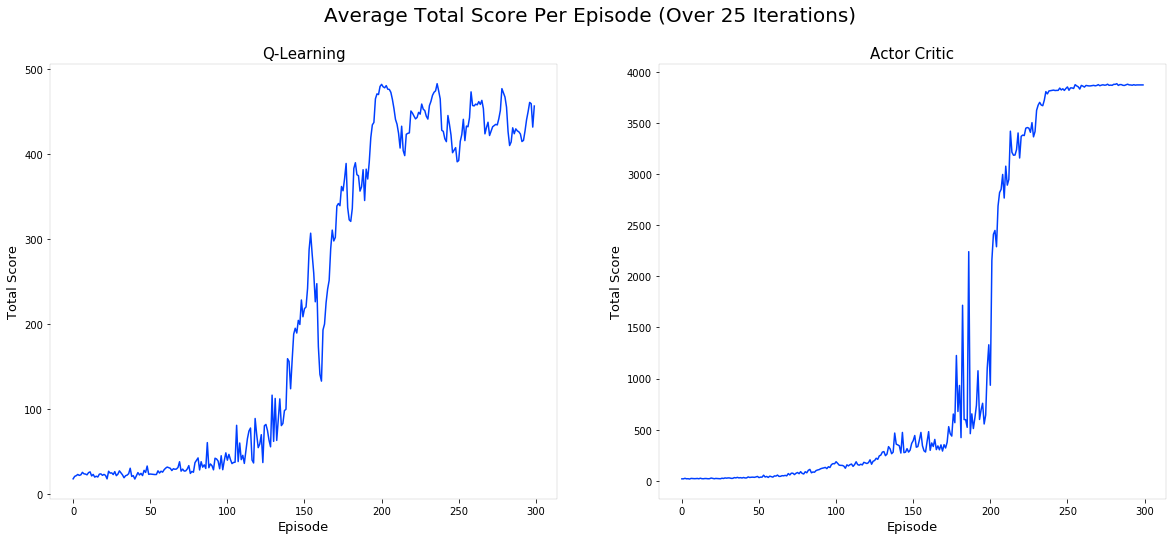

In [78]:
# visualising the results (Increasing rewards per epsiode)
plt.style.use('seaborn-bright')
plt.rcParams['axes.linewidth'] = 0.1
plt.figure(figsize=(20,8))
plt.suptitle("Average Total Score Per Episode (Over 25 Iterations)", fontsize = 20)
plt.subplot(121)
x1 = np.arange(0, len(average_rewards))
plt.plot(x1, average_rewards) 
plt.title('Q-Learning', fontsize = 15)
plt.xlabel('Episode', fontsize = 13)
plt.ylabel('Total Score', fontsize = 13)

plt.subplot(122)
x2 = np.arange(0, len(ave_scores))
plt.plot(x2, ave_scores)
plt.title('Actor Critic', fontsize = 15)
plt.xlabel('Episode', fontsize = 13)
plt.ylabel('Total Score', fontsize = 13)
plt.show()